In [31]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageEnhance, ImageOps, ImageStat
from glob import glob
from skimage import filters, exposure, util
from tqdm import tqdm
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Path to your image folder and CSV file
image_folder = 'labeled-images/Final'
csv_path = 'labeled-images/image-labels.csv'

In [3]:
# Load the CSV file
df = pd.read_csv(csv_path)

In [4]:
df

Video file     Organ          Finding  \
0      000e3fee-7f5c-4819-9f9c-4c983b68888a  Lower GI            cecum   
1      001a41c2-2a5d-40b1-8fd5-b5f2f292277b  Lower GI            cecum   
2      006af0aa-2044-4477-964d-10d9e043fb78  Lower GI            cecum   
3      00832522-ab8e-4b98-bfce-93a777929571  Lower GI            cecum   
4      012ab888-64e6-4361-9745-f52b4a03ba75  Lower GI            cecum   
...                                     ...       ...              ...   
10657  f7dd198b-88f0-4566-b8f4-81c8c2fee1ed  Upper GI  esophagitis-b-d   
10658  f9a06ca3-3500-4e5e-ac46-110b52963a99  Upper GI  esophagitis-b-d   
10659  fb31e2c2-c8db-42b3-bbf1-564e42076a8e  Upper GI  esophagitis-b-d   
10660  fe6c191e-3da0-4f18-9e38-8f7a11097a3b  Upper GI  esophagitis-b-d   
10661  ff4f2ed2-69a8-455d-894a-8d536b324653  Upper GI  esophagitis-b-d   

              Classification  
0       anatomical-landmarks  
1       anatomical-landmarks  
2       anatomical-landmarks  
3       anatomical-landmarks  
4       anatomical-landmarks  
...                      ...  
10657  pathological-findings  
10658  pathological-findings  
10659  pathological-findings  
10660  pathological-findings  
10661  pathological-findings  

[10662 rows x 4 columns]

In [5]:
df.columns = [col.strip() for col in df.columns]  # Strip column names

In [6]:
# Create a dictionary of image name (without extension) to full path
image_extensions = ['*.jpg', '*.jpeg', '*.png']
image_files = []
for ext in image_extensions:
    image_files.extend(glob(os.path.join(image_folder, ext)))

In [7]:
# Map image names (without extension) to their full path
image_map = {os.path.splitext(os.path.basename(path))[0]: path for path in image_files}

In [8]:
# Map paths to DataFrame
df['Image_Path'] = df['Video file'].map(image_map)

In [9]:
# Optionally filter rows with valid image paths only
df = df[df['Image_Path'].notnull()]

In [10]:
df.head()

Video file     Organ            Finding  \
8209  005f1aa1-cfc7-4a68-b7d3-080eea906784  Upper GI  retroflex-stomach   
8210  0069a719-31a3-4b07-a58d-9832e72f11fc  Upper GI  retroflex-stomach   
8211  009766c6-9636-4704-81bc-02c961ba166e  Upper GI  retroflex-stomach   
8212  0098fd42-5b1e-4d17-89f6-3b395f770045  Upper GI  retroflex-stomach   
8213  00bcc53a-a760-4a88-9265-80120f5fdeca  Upper GI  retroflex-stomach   

            Classification                                         Image_Path  
8209  anatomical-landmarks  labeled-images/Final/005f1aa1-cfc7-4a68-b7d3-0...  
8210  anatomical-landmarks  labeled-images/Final/0069a719-31a3-4b07-a58d-9...  
8211  anatomical-landmarks  labeled-images/Final/009766c6-9636-4704-81bc-0...  
8212  anatomical-landmarks  labeled-images/Final/0098fd42-5b1e-4d17-89f6-3...  
8213  anatomical-landmarks  labeled-images/Final/00bcc53a-a760-4a88-9265-8...

# EDA

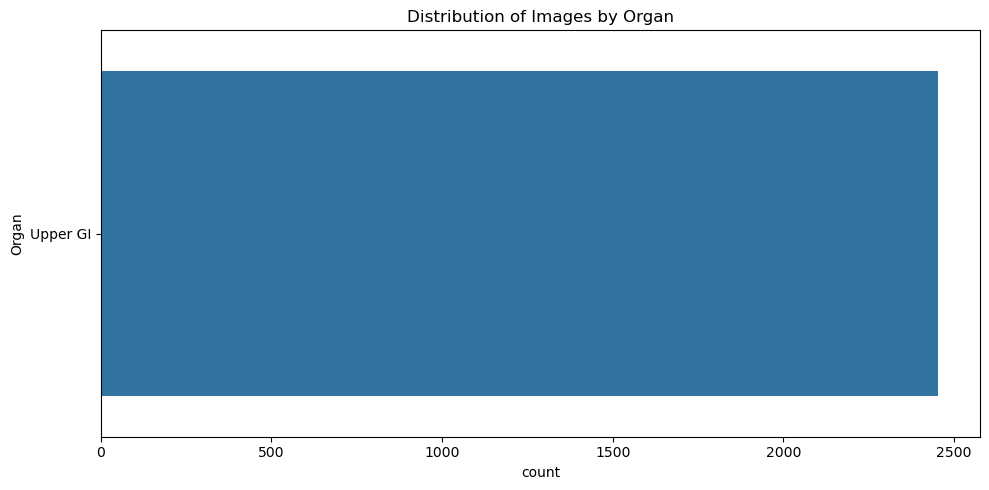

In [13]:
# Plot: Organ Distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='Organ', order=df['Organ'].value_counts().index)
plt.title('Distribution of Images by Organ')
plt.tight_layout()
plt.show()


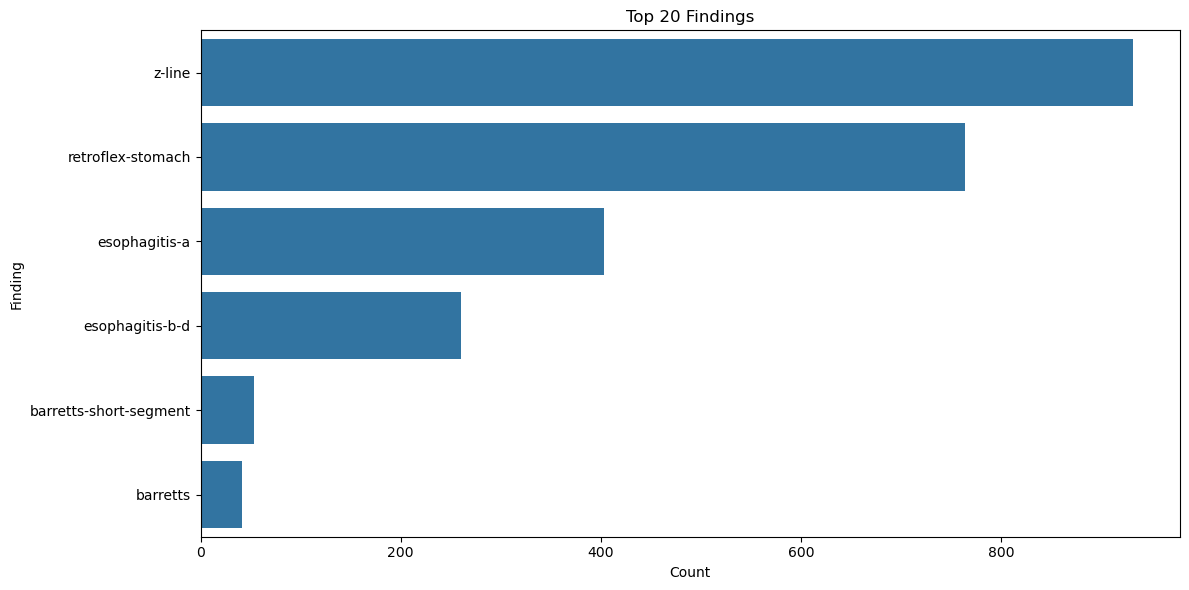

In [14]:
# Plot: Top 20 Findings
plt.figure(figsize=(12, 6))
top_findings = df['Finding'].value_counts().nlargest(20)
sns.barplot(x=top_findings.values, y=top_findings.index)
plt.title('Top 20 Findings')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

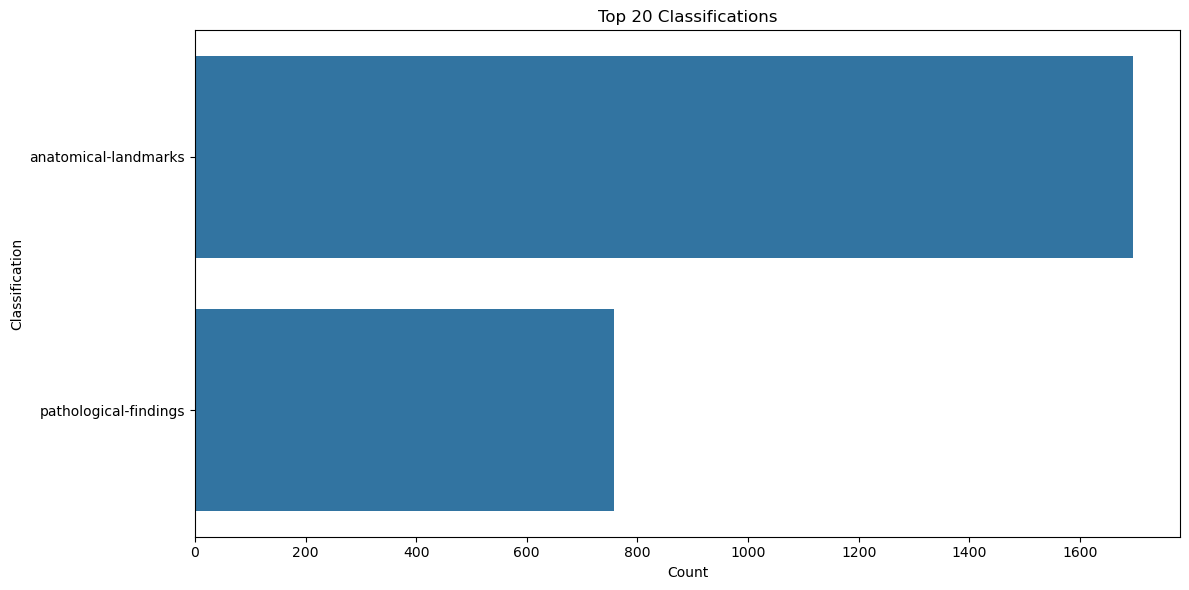

In [15]:
# Plot: Top 20 Classifications
plt.figure(figsize=(12, 6))
top_classes = df['Classification'].value_counts().nlargest(20)
sns.barplot(x=top_classes.values, y=top_classes.index)
plt.title('Top 20 Classifications')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

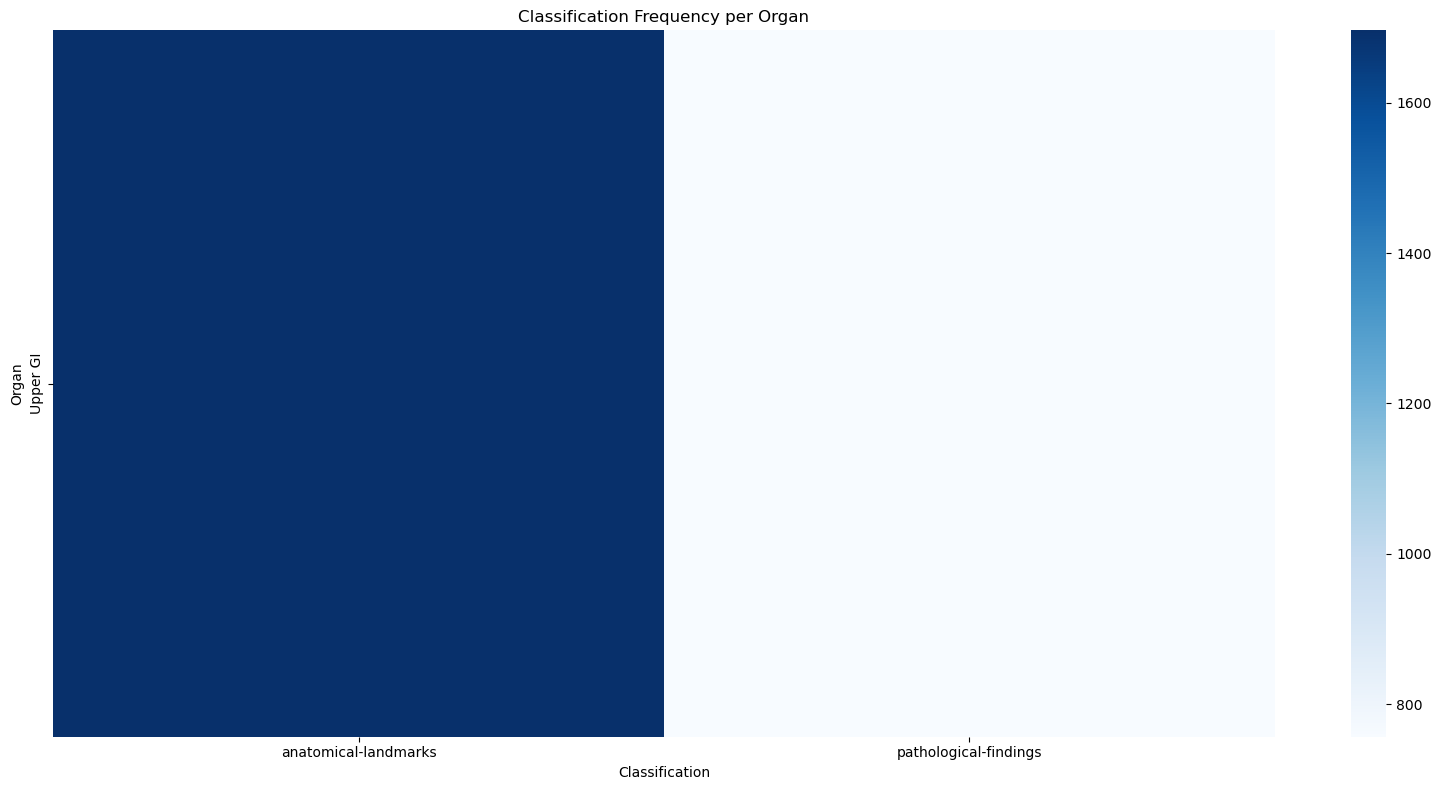

In [16]:
# --- Heatmap: Frequency of Classification per Organ ---
pivot = df.pivot_table(index='Organ', columns='Classification', aggfunc='size', fill_value=0)
plt.figure(figsize=(16, 8))
sns.heatmap(pivot, cmap='Blues', annot=False)
plt.title('Classification Frequency per Organ')
plt.tight_layout()
plt.show()

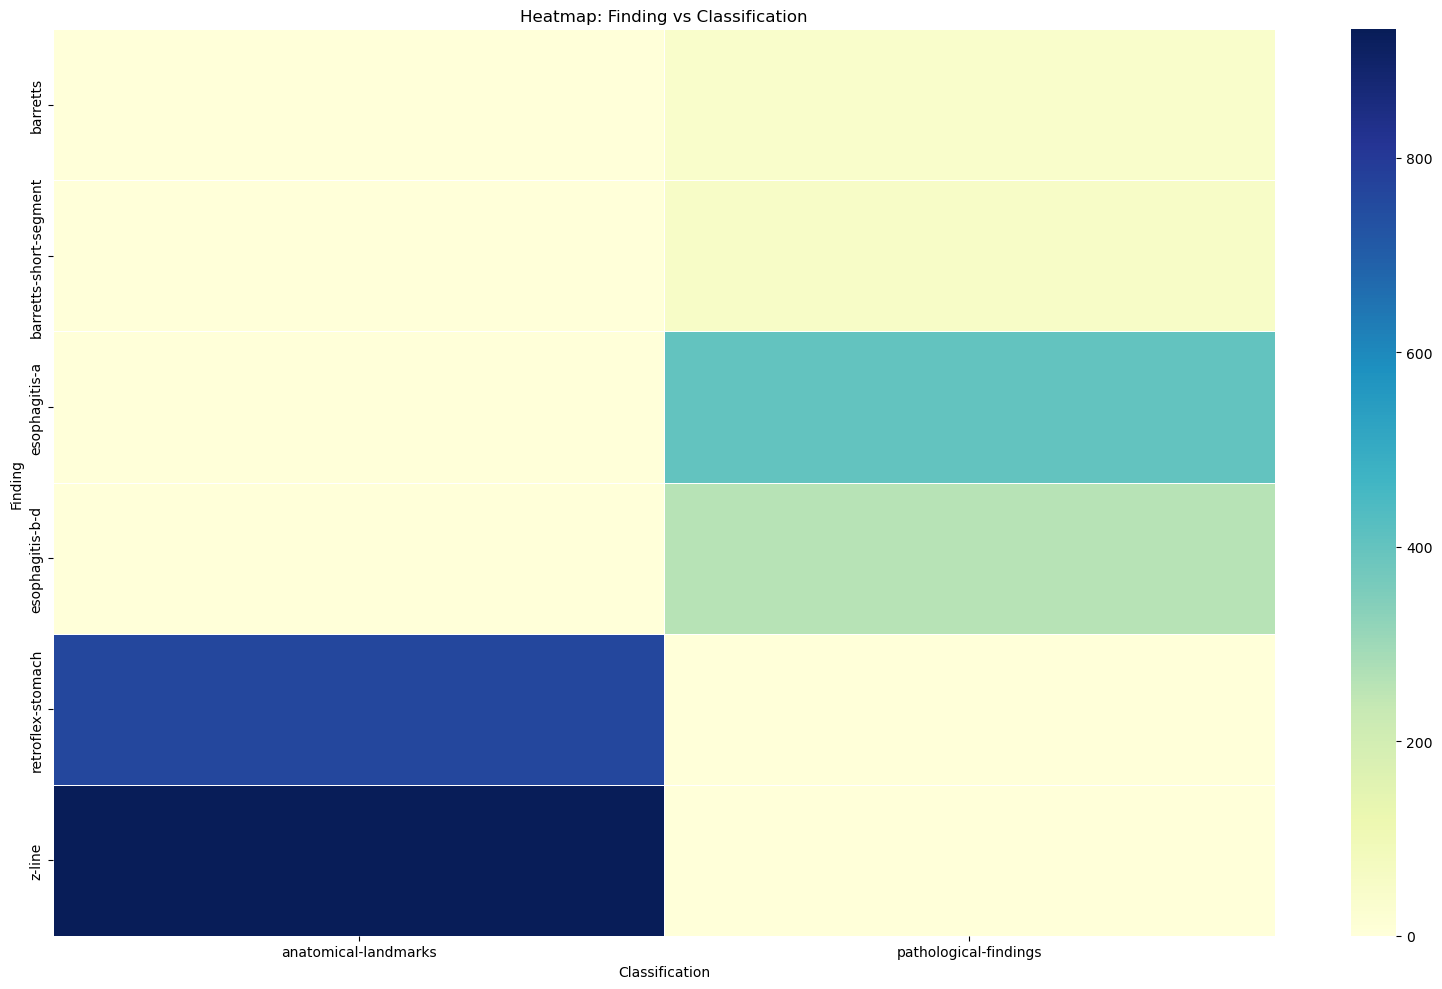

In [17]:
# --- Plot 2: Finding vs Classification Heatmap ---
cross_tab_fc = pd.crosstab(df['Finding'], df['Classification'])
plt.figure(figsize=(16, 10))
sns.heatmap(cross_tab_fc, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap: Finding vs Classification')
plt.xlabel('Classification')
plt.ylabel('Finding')
plt.tight_layout()
plt.show()






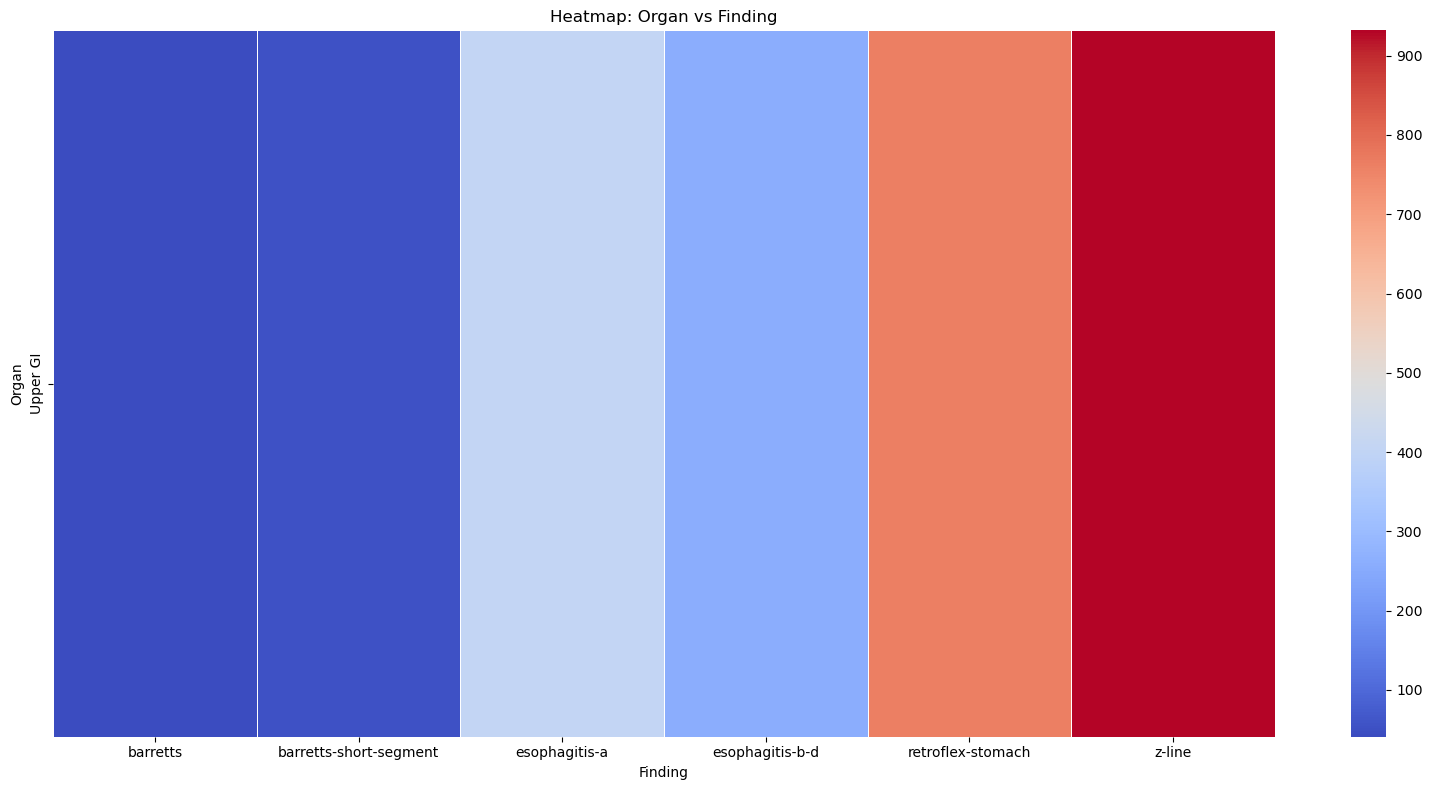

In [18]:
# --- Plot 3: Organ vs Finding Heatmap ---
cross_tab_of = pd.crosstab(df['Organ'], df['Finding'])
plt.figure(figsize=(16, 8))
sns.heatmap(cross_tab_of, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap: Organ vs Finding')
plt.xlabel('Finding')
plt.ylabel('Organ')
plt.tight_layout()
plt.show()


In [32]:
# --- Analysis functions ---
def get_image_metrics(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
        stat = ImageStat.Stat(img)

        # RGB mean
        r, g, b = stat.mean

        # Brightness: Average of mean RGB
        brightness = (r + g + b) / 3

        # Sharpness: Variance of Laplacian (clarity)
        img_gray = img.convert('L')
        gray_np = np.array(img_gray)
        sharpness = filters.laplace(gray_np).var()

        return pd.Series([r, g, b, brightness, sharpness])
    except:
        return pd.Series([np.nan]*5)

In [33]:
# Apply to DataFrame
df[['R_mean', 'G_mean', 'B_mean', 'Brightness', 'Sharpness']] = df['Image_Path'].apply(get_image_metrics)

/var/folders/9d/0ryfzgmn2xj9q__7d2tv8q_m0000gn/T/ipykernel_58777/2422782332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['R_mean', 'G_mean', 'B_mean', 'Brightness', 'Sharpness']] = df['Image_Path'].apply(get_image_metrics)


In [34]:
df

Video file     Organ            Finding  \
8209   005f1aa1-cfc7-4a68-b7d3-080eea906784  Upper GI  retroflex-stomach   
8210   0069a719-31a3-4b07-a58d-9832e72f11fc  Upper GI  retroflex-stomach   
8211   009766c6-9636-4704-81bc-02c961ba166e  Upper GI  retroflex-stomach   
8212   0098fd42-5b1e-4d17-89f6-3b395f770045  Upper GI  retroflex-stomach   
8213   00bcc53a-a760-4a88-9265-80120f5fdeca  Upper GI  retroflex-stomach   
...                                     ...       ...                ...   
10657  f7dd198b-88f0-4566-b8f4-81c8c2fee1ed  Upper GI    esophagitis-b-d   
10658  f9a06ca3-3500-4e5e-ac46-110b52963a99  Upper GI    esophagitis-b-d   
10659  fb31e2c2-c8db-42b3-bbf1-564e42076a8e  Upper GI    esophagitis-b-d   
10660  fe6c191e-3da0-4f18-9e38-8f7a11097a3b  Upper GI    esophagitis-b-d   
10661  ff4f2ed2-69a8-455d-894a-8d536b324653  Upper GI    esophagitis-b-d   

              Classification  \
8209    anatomical-landmarks   
8210    anatomical-landmarks   
8211    anatomical-landmarks   
8212    anatomical-landmarks   
8213    anatomical-landmarks   
...                      ...   
10657  pathological-findings   
10658  pathological-findings   
10659  pathological-findings   
10660  pathological-findings   
10661  pathological-findings   

                                              Image_Path      R_mean  \
8209   labeled-images/Final/005f1aa1-cfc7-4a68-b7d3-0...  166.650858   
8210   labeled-images/Final/0069a719-31a3-4b07-a58d-9...  174.278801   
8211   labeled-images/Final/009766c6-9636-4704-81bc-0...  124.500319   
8212   labeled-images/Final/0098fd42-5b1e-4d17-89f6-3...  119.335750   
8213   labeled-images/Final/00bcc53a-a760-4a88-9265-8...  104.760848   
...                                                  ...         ...   
10657  labeled-images/Final/f7dd198b-88f0-4566-b8f4-8...  138.993075   
10658  labeled-images/Final/f9a06ca3-3500-4e5e-ac46-1...  170.065709   
10659  labeled-images/Final/fb31e2c2-c8db-42b3-bbf1-5...  128.241770   
10660  labeled-images/Final/fe6c191e-3da0-4f18-9e38-8...  156.461713   
10661  labeled-images/Final/ff4f2ed2-69a8-455d-894a-8...  167.285136   

           G_mean      B_mean  Brightness  Sharpness  
8209   113.195229  102.754931  127.533673   0.001638  
8210   125.278876  117.740950  139.099542   0.001850  
8211    80.217915   78.655007   94.457747   0.001809  
8212    81.510114   67.430333   89.425399   0.015375  
8213    71.059359   56.536841   77.452349   0.000987  
...           ...         ...         ...        ...  
10657   97.460566   84.985476  107.146372   0.000887  
10658  130.865180  133.378775  144.769888   0.008055  
10659   92.399948   94.903121  105.181613   0.001498  
10660  100.560684   89.065423  115.362607   0.001031  
10661  120.262254  121.568571  136.371987   0.006906  

[2453 rows x 10 columns]

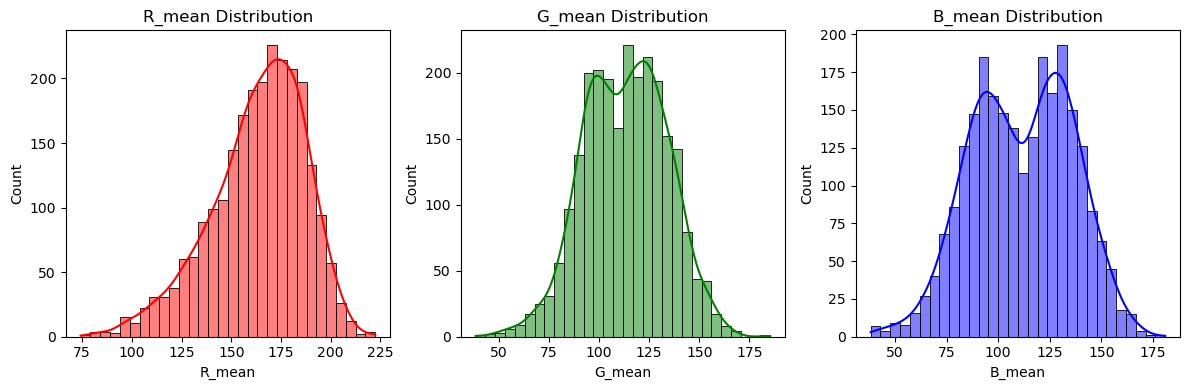

In [35]:
# --- Plot 1: RGB Channel Histograms ---
plt.figure(figsize=(12, 4))
for i, color in enumerate(['R_mean', 'G_mean', 'B_mean']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[color], bins=30, kde=True, color=color[0].lower())
    plt.title(f'{color} Distribution')
plt.tight_layout()
plt.show()

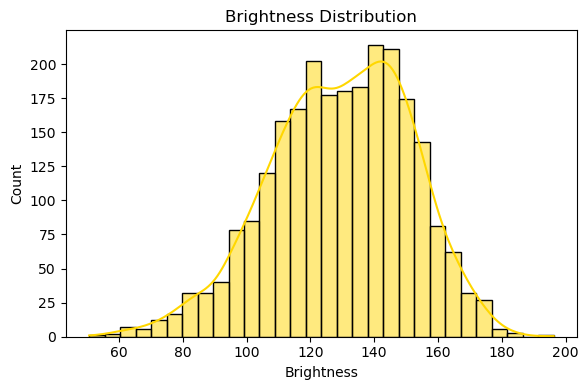

In [36]:
# --- Plot 2: Brightness Distribution ---
plt.figure(figsize=(6, 4))
sns.histplot(df['Brightness'], bins=30, kde=True, color='gold')
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.tight_layout()
plt.show()

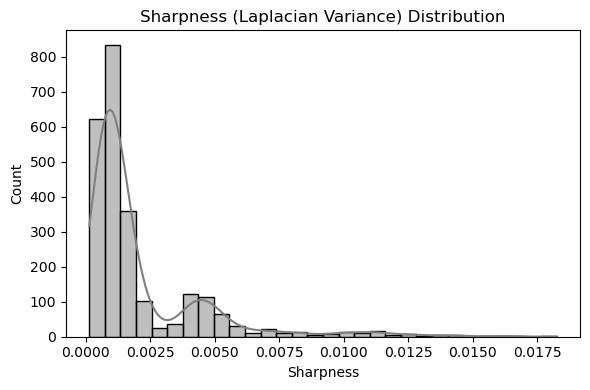

In [38]:
# --- Plot 3: Sharpness Distribution ---
plt.figure(figsize=(6, 4))
sns.histplot(df['Sharpness'], bins=30, kde=True, color='gray')
plt.title('Sharpness (Laplacian Variance) Distribution')
plt.xlabel('Sharpness')
plt.tight_layout()
plt.show()

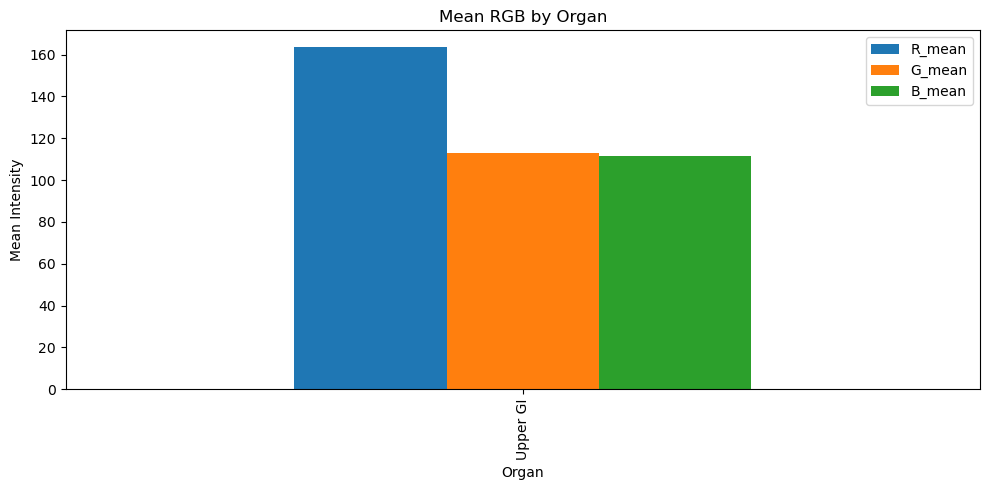

In [40]:
# --- Plot 4: Mean RGB per Organ (if available) ---
if 'Organ' in df.columns:
    rgb_means_by_organ = df.groupby('Organ')[['R_mean', 'G_mean', 'B_mean']].mean()
    rgb_means_by_organ.plot(kind='bar', figsize=(10, 5))
    plt.title('Mean RGB by Organ')
    plt.ylabel('Mean Intensity')
    plt.tight_layout()
    plt.show()

/var/folders/9d/0ryfzgmn2xj9q__7d2tv8q_m0000gn/T/ipykernel_58777/1477602415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Aspect_Ratio'] = df['Image_Path'].apply(lambda p: Image.open(p).size[0] / Image.open(p).size[1])


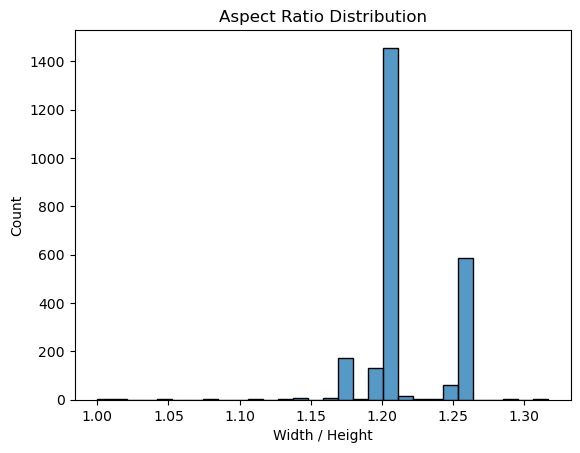

In [42]:
df['Aspect_Ratio'] = df['Image_Path'].apply(lambda p: Image.open(p).size[0] / Image.open(p).size[1])
sns.histplot(df['Aspect_Ratio'], bins=30)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Width / Height')
plt.show()


/var/folders/9d/0ryfzgmn2xj9q__7d2tv8q_m0000gn/T/ipykernel_58777/2486018102.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Saturation'] = df['Image_Path'].apply(get_saturation)


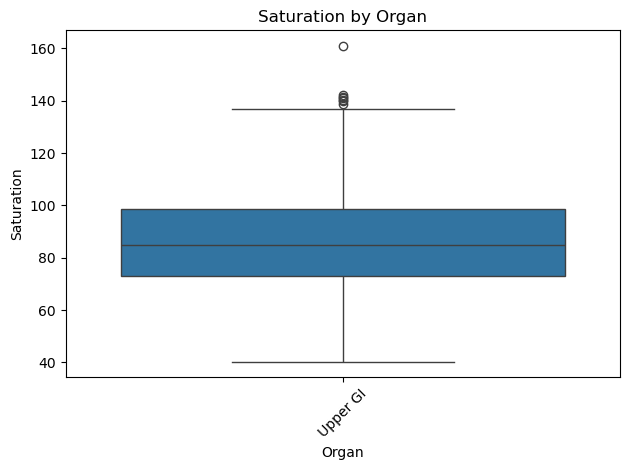

In [43]:
from PIL import ImageEnhance

def get_saturation(path):
    img = Image.open(path).convert('RGB')
    hsv = img.convert('HSV')
    return np.array(hsv)[:, :, 1].mean()  # average saturation

df['Saturation'] = df['Image_Path'].apply(get_saturation)

sns.boxplot(data=df, x='Organ', y='Saturation')
plt.xticks(rotation=45)
plt.title('Saturation by Organ')
plt.tight_layout()
plt.show()


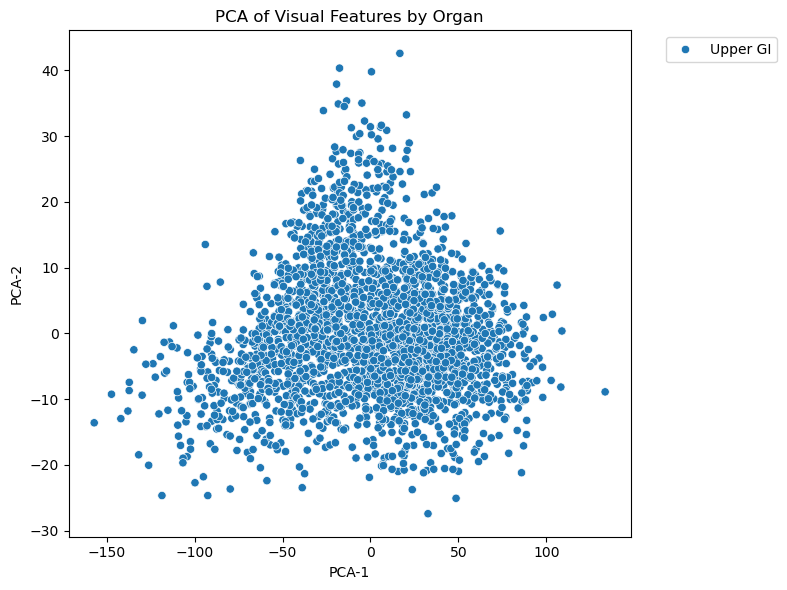

In [44]:
from sklearn.decomposition import PCA
features = df[['R_mean', 'G_mean', 'B_mean', 'Brightness', 'Sharpness']].dropna()
labels = df.loc[features.index, 'Organ']

pca = PCA(n_components=2)
components = pca.fit_transform(features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=components[:,0], y=components[:,1], hue=labels)
plt.title('PCA of Visual Features by Organ')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


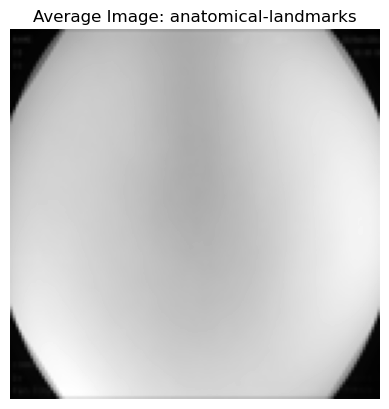

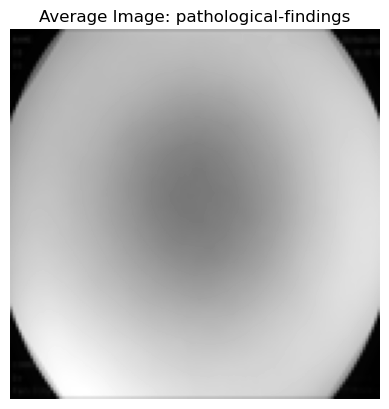

In [45]:
from PIL import Image
import numpy as np

def average_images(image_paths):
    stack = []
    for p in image_paths:
        img = Image.open(p).resize((128, 128)).convert('L')  # grayscale
        stack.append(np.array(img))
    return np.mean(stack, axis=0)

top_classes = df['Classification'].value_counts().head(3).index
for cls in top_classes:
    paths = df[df['Classification'] == cls]['Image_Path'].tolist()
    avg_img = average_images(paths)
    plt.imshow(avg_img, cmap='gray')
    plt.title(f"Average Image: {cls}")
    plt.axis('off')
    plt.show()


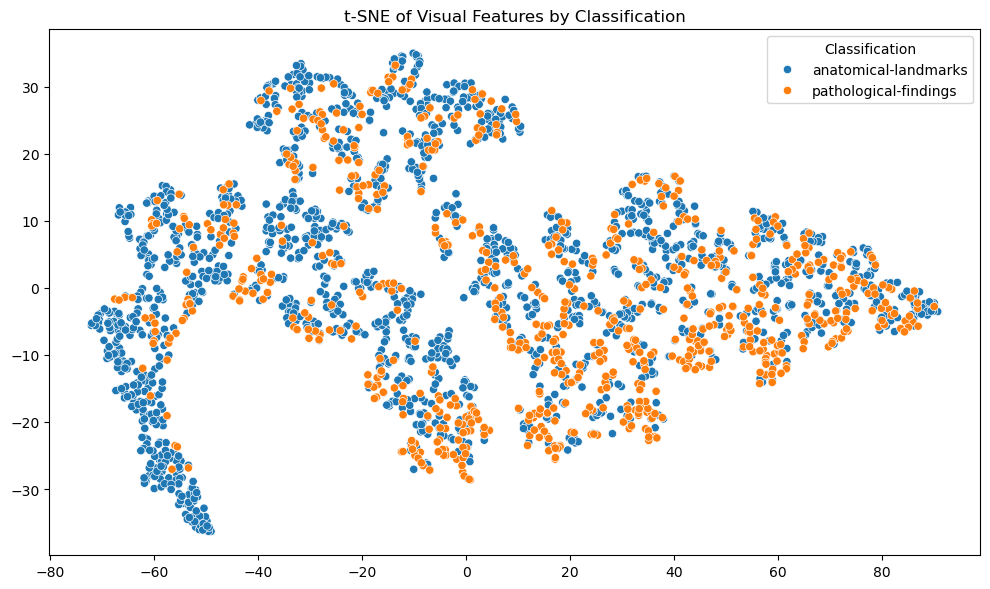

In [46]:
from sklearn.manifold import TSNE
features = df[['R_mean', 'G_mean', 'B_mean', 'Brightness', 'Sharpness']].dropna()
labels = df.loc[features.index, 'Classification']

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=labels, palette='tab10')
plt.title('t-SNE of Visual Features by Classification')
plt.tight_layout()
plt.show()


# Data PREPROCESSING

In [49]:
# Preprocess function
def preprocess_image_pil(img_path, resize_dim=(224, 224), augment=False):
    try:
        # Load image and grayscale
        img = Image.open(img_path).convert('L')
        img = img.resize(resize_dim)

        # Apply augmentations (optional)
        if augment:
            if random.random() > 0.5:
                img = ImageOps.mirror(img)  # Horizontal flip

            if random.random() > 0.5:
                angle = random.choice([-15, -10, 10, 15])
                img = img.rotate(angle)

            if random.random() > 0.5:
                enhancer = ImageEnhance.Brightness(img)
                img = enhancer.enhance(random.uniform(0.8, 1.2))

            if random.random() > 0.5:
                enhancer = ImageEnhance.Contrast(img)
                img = enhancer.enhance(random.uniform(0.8, 1.2))

        # Convert to numpy
        img_array = np.array(img)

        # Gaussian blur for noise reduction
        img_array = filters.gaussian(img_array, sigma=1)

        # Histogram equalization
        img_array = exposure.equalize_hist(img_array)

        # Normalize
        img_array = util.img_as_float(img_array)

        return img_array
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [50]:

# Process all images (with and without augmentation)
processed_images = []
processed_labels = []

In [51]:
for _, row in tqdm(df.iterrows(), total=len(df)):
    base_image = preprocess_image_pil(row['Image_Path'], augment=False)
    aug_image = preprocess_image_pil(row['Image_Path'], augment=True)

    if base_image is not None:
        processed_images.append(base_image)
        processed_labels.append(row['Finding'])  # Or any column you need

    if aug_image is not None:
        processed_images.append(aug_image)
        processed_labels.append(row['Finding'])


100%|███████████████████████████████████████| 2453/2453 [00:59<00:00, 40.90it/s]


In [52]:
# Convert to NumPy arrays
X = np.array(processed_images)
y = np.array(processed_labels)

In [53]:
print("Processed dataset shape:", X.shape)
print("Sample label distribution:", pd.Series(y).value_counts())

Processed dataset shape: (4906, 224, 224)
Sample label distribution: z-line                    1864
retroflex-stomach         1528
esophagitis-a              806
esophagitis-b-d            520
barretts-short-segment     106
barretts                    82
Name: count, dtype: int64


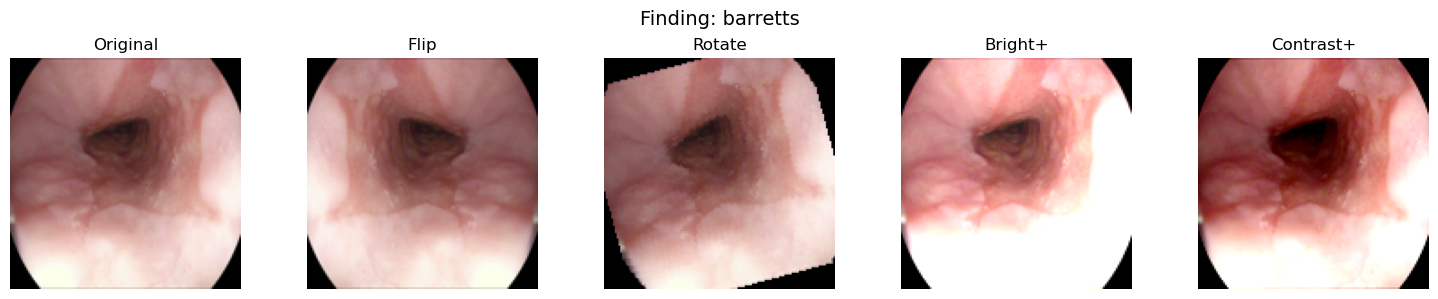

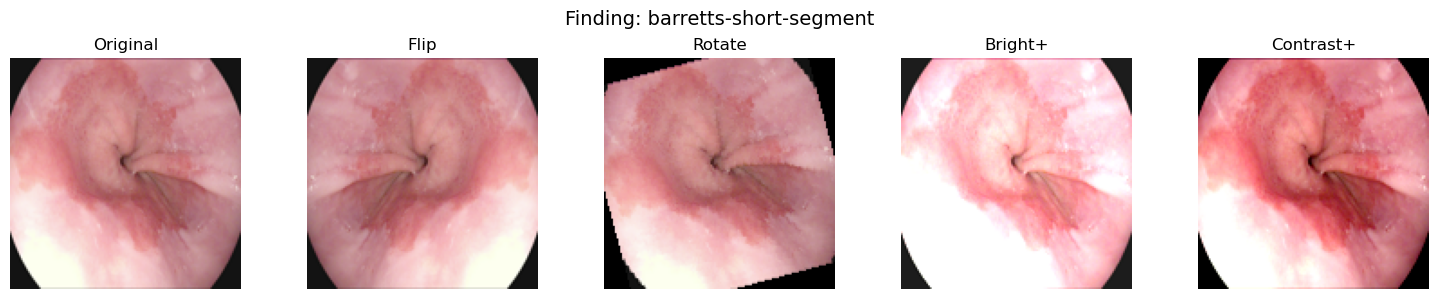

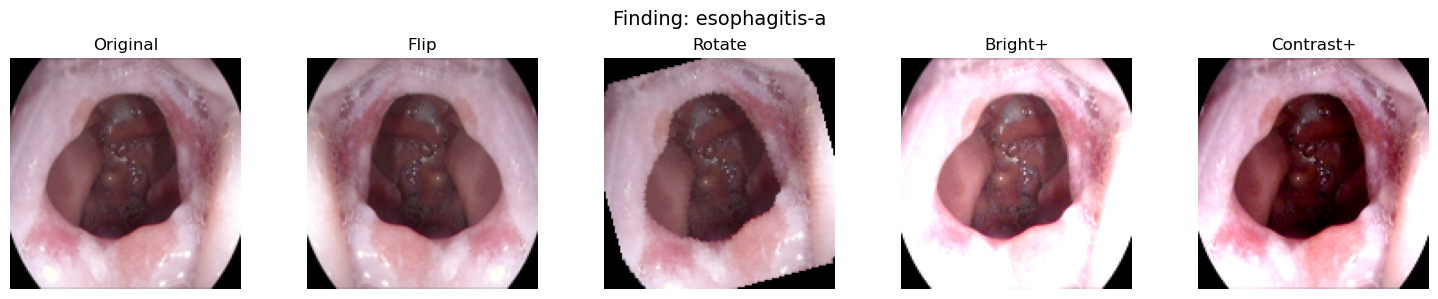

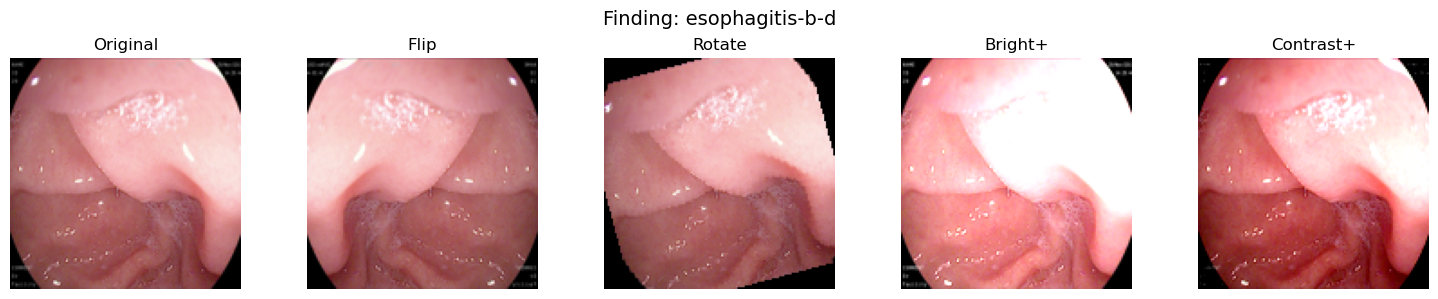

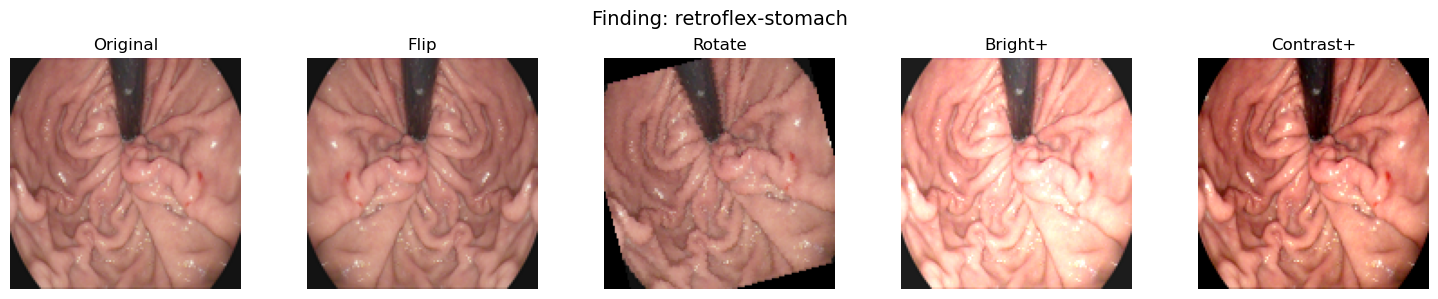

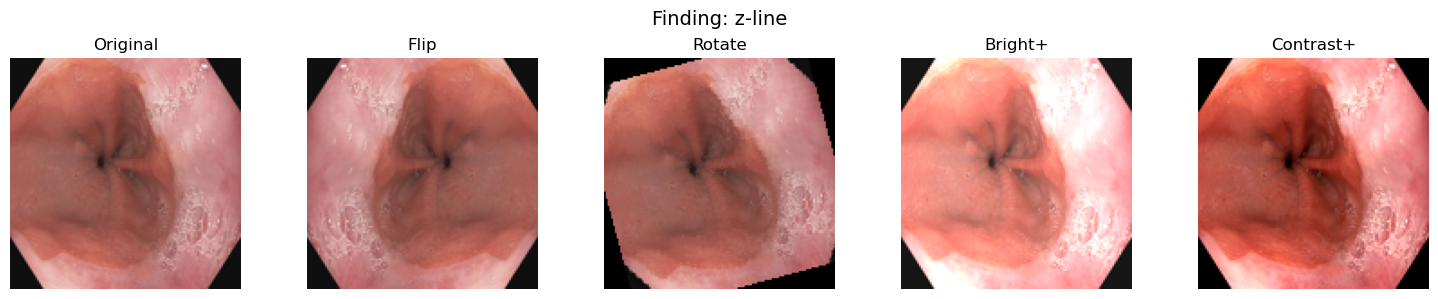

In [55]:
# --- ONE IMAGE PER FINDING ---
unique_findings = df['Finding'].unique()
sample_df = df.groupby('Finding').first().reset_index()  # one sample per finding

# --- AUGMENTATION FUNCTION ---
def augment_image(img):
    return [
        img,  # Original
        ImageOps.mirror(img),  # Horizontal Flip
        img.rotate(15),  # Rotation
        ImageEnhance.Brightness(img).enhance(1.5),  # Brightness
        ImageEnhance.Contrast(img).enhance(1.5)  # Contrast
    ]
image_size = (128, 128)
# --- DISPLAY ---
for _, row in sample_df.iterrows():
    try:
        img = Image.open(row['Image_Path']).convert('RGB').resize(image_size)
        aug_imgs = augment_image(img)

        fig, axes = plt.subplots(1, len(aug_imgs), figsize=(15, 3))
        for i, aug in enumerate(aug_imgs):
            axes[i].imshow(aug)
            axes[i].axis('off')
            axes[i].set_title(['Original', 'Flip', 'Rotate', 'Bright+', 'Contrast+'][i])
        fig.suptitle(f"Finding: {row['Finding']}", fontsize=14)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Skipping {row['Finding']} due to error: {e}")

In [56]:
df

Video file     Organ            Finding  \
8209   005f1aa1-cfc7-4a68-b7d3-080eea906784  Upper GI  retroflex-stomach   
8210   0069a719-31a3-4b07-a58d-9832e72f11fc  Upper GI  retroflex-stomach   
8211   009766c6-9636-4704-81bc-02c961ba166e  Upper GI  retroflex-stomach   
8212   0098fd42-5b1e-4d17-89f6-3b395f770045  Upper GI  retroflex-stomach   
8213   00bcc53a-a760-4a88-9265-80120f5fdeca  Upper GI  retroflex-stomach   
...                                     ...       ...                ...   
10657  f7dd198b-88f0-4566-b8f4-81c8c2fee1ed  Upper GI    esophagitis-b-d   
10658  f9a06ca3-3500-4e5e-ac46-110b52963a99  Upper GI    esophagitis-b-d   
10659  fb31e2c2-c8db-42b3-bbf1-564e42076a8e  Upper GI    esophagitis-b-d   
10660  fe6c191e-3da0-4f18-9e38-8f7a11097a3b  Upper GI    esophagitis-b-d   
10661  ff4f2ed2-69a8-455d-894a-8d536b324653  Upper GI    esophagitis-b-d   

              Classification  \
8209    anatomical-landmarks   
8210    anatomical-landmarks   
8211    anatomical-landmarks   
8212    anatomical-landmarks   
8213    anatomical-landmarks   
...                      ...   
10657  pathological-findings   
10658  pathological-findings   
10659  pathological-findings   
10660  pathological-findings   
10661  pathological-findings   

                                              Image_Path      R_mean  \
8209   labeled-images/Final/005f1aa1-cfc7-4a68-b7d3-0...  166.650858   
8210   labeled-images/Final/0069a719-31a3-4b07-a58d-9...  174.278801   
8211   labeled-images/Final/009766c6-9636-4704-81bc-0...  124.500319   
8212   labeled-images/Final/0098fd42-5b1e-4d17-89f6-3...  119.335750   
8213   labeled-images/Final/00bcc53a-a760-4a88-9265-8...  104.760848   
...                                                  ...         ...   
10657  labeled-images/Final/f7dd198b-88f0-4566-b8f4-8...  138.993075   
10658  labeled-images/Final/f9a06ca3-3500-4e5e-ac46-1...  170.065709   
10659  labeled-images/Final/fb31e2c2-c8db-42b3-bbf1-5...  128.241770   
10660  labeled-images/Final/fe6c191e-3da0-4f18-9e38-8...  156.461713   
10661  labeled-images/Final/ff4f2ed2-69a8-455d-894a-8...  167.285136   

           G_mean      B_mean  Brightness  Sharpness  Aspect_Ratio  Saturation  
8209   113.195229  102.754931  127.533673   0.001638      1.209279   94.261693  
8210   125.278876  117.740950  139.099542   0.001850      1.206522   82.839690  
8211    80.217915   78.655007   94.457747   0.001809      1.210474   99.901132  
8212    81.510114   67.430333   89.425399   0.015375      1.197059  117.310262  
8213    71.059359   56.536841   77.452349   0.000987      1.210474  116.729265  
...           ...         ...         ...        ...           ...         ...  
10657   97.460566   84.985476  107.146372   0.000887      1.259570   94.965870  
10658  130.865180  133.378775  144.769888   0.008055      1.195886   62.910787  
10659   92.399948   94.903121  105.181613   0.001498      1.206522   77.199529  
10660  100.560684   89.065423  115.362607   0.001031      1.259570  103.201356  
10661  120.262254  121.568571  136.371987   0.006906      1.195886   78.835545  

[2453 rows x 12 columns]

In [59]:
y

array(['retroflex-stomach', 'retroflex-stomach', 'retroflex-stomach', ...,
       'esophagitis-b-d', 'esophagitis-b-d', 'esophagitis-b-d'],
      dtype='<U22')

# VGG16

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize

In [61]:
# Step 1: Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

In [62]:
# Step 2: Preprocess for VGG: grayscale to RGB
X_rgb = np.repeat(X[:, np.newaxis, :, :], 3, axis=1)  # [N, 3, 224, 224]


In [63]:
# Step 3: Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_rgb, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [64]:
# Step 4: Custom Dataset
class ImageDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [65]:
train_loader = DataLoader(ImageDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(ImageDataset(X_val, y_val), batch_size=32)


In [66]:
# Step 5: Load VGG16 and modify classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = models.vgg16(pretrained=True)
for param in vgg.features.parameters():
    param.requires_grad = False  # Freeze convolutional layers


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/shreyashindurkar/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|████████████████████████████████████████| 528M/528M [01:51<00:00, 4.98MB/s]


In [67]:
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, num_classes)  # Replace final layer
vgg = vgg.to(device)

In [68]:
# Step 6: Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.classifier.parameters(), lr=0.0001)

In [70]:
# Step 7: Training loop
for epoch in range(5):  # Adjust epochs as needed
    vgg.train()
    total_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")


100%|█████████████████████████████████████████| 123/123 [05:57<00:00,  2.91s/it]


Epoch 1: Loss = 96.1324


100%|█████████████████████████████████████████| 123/123 [05:58<00:00,  2.92s/it]


Epoch 2: Loss = 72.2112


100%|█████████████████████████████████████████| 123/123 [06:00<00:00,  2.93s/it]


Epoch 3: Loss = 53.0371


100%|█████████████████████████████████████████| 123/123 [05:46<00:00,  2.82s/it]


Epoch 4: Loss = 35.2110


100%|█████████████████████████████████████████| 123/123 [05:47<00:00,  2.83s/it]

Epoch 5: Loss = 22.9924


In [71]:
# Step 8: Evaluation
vgg.eval()
all_preds, all_probs, all_targets = [], [], []

In [72]:
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = vgg(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(labels.numpy())


In [73]:
# Step 9: Metrics
print(classification_report(all_targets, all_preds, target_names=le.classes_))

                        precision    recall  f1-score   support

              barretts       0.83      0.29      0.43        17
barretts-short-segment       0.56      0.43      0.49        21
         esophagitis-a       0.66      0.35      0.46       161
       esophagitis-b-d       0.66      0.83      0.74       104
     retroflex-stomach       0.98      1.00      0.99       306
                z-line       0.76      0.89      0.82       373

              accuracy                           0.81       982
             macro avg       0.74      0.63      0.65       982
          weighted avg       0.80      0.81      0.79       982



In [74]:
# AUC score
y_true_bin = label_binarize(all_targets, classes=list(range(num_classes)))
y_prob_bin = np.array(all_probs)
auc = roc_auc_score(y_true_bin, y_prob_bin, average='macro', multi_class='ovr')
print(f"Macro AUC Score: {auc:.4f}")

Macro AUC Score: 0.9347


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_multiclass_auc(all_targets, all_probs, class_names=None):
    """
    Plots AUC curves for multi-class classification.
    
    Parameters:
        all_targets: list or np.array of true class labels (ints)
        all_probs: np.array of predicted probabilities [n_samples, n_classes]
        class_names: list of class label names (optional)
    """
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    num_classes = all_probs.shape[1]

    # Binarize the true labels
    y_true_bin = label_binarize(all_targets, classes=list(range(num_classes)))

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        label = f"Class {i}" if class_names is None else f"{class_names[i]}"
        plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC (AUC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


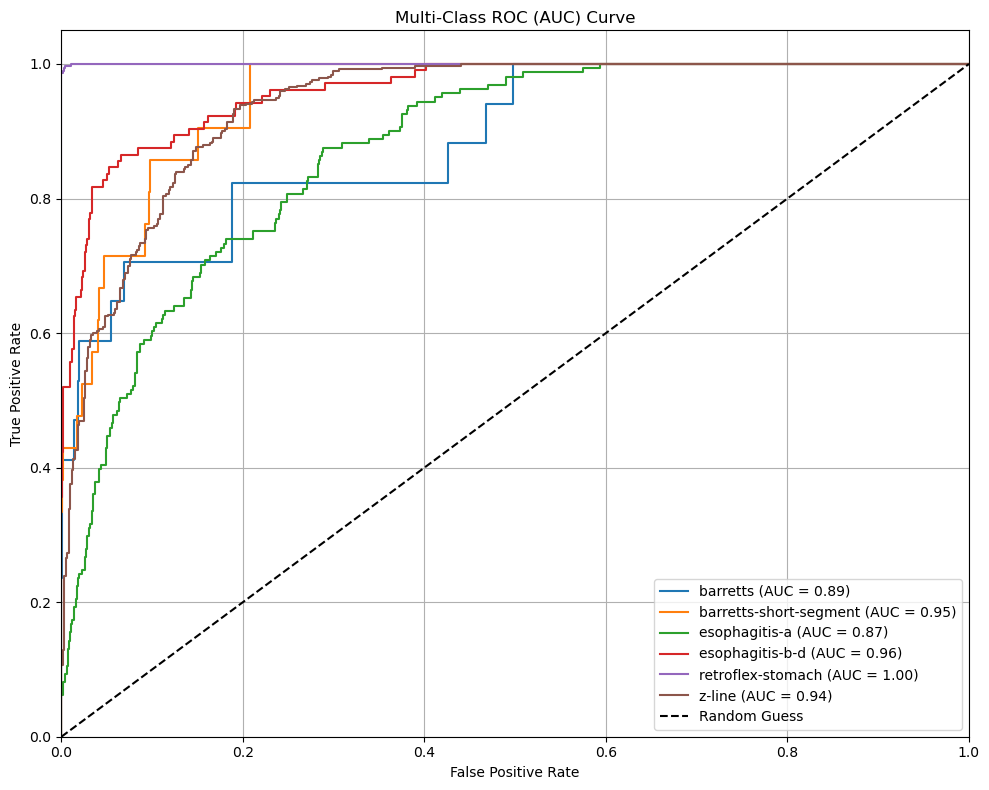

In [76]:
# Example usage
plot_multiclass_auc(all_targets, all_probs, class_names=le.classes_)

# ResNet50

In [78]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
num_classes = len(class_names)

In [79]:
# Expand grayscale to 3 channels
X_rgb = np.repeat(X[:, np.newaxis, :, :], 3, axis=1)  # shape: (N, 3, 224, 224)


In [80]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_rgb, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [81]:
# PyTorch Dataset
class ImageDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]


In [82]:
train_loader = DataLoader(ImageDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(ImageDataset(X_val, y_val), batch_size=32)


In [83]:
# Load ResNet-50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/shreyashindurkar/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████████████████████████████████| 97.8M/97.8M [00:20<00:00, 4.91MB/s]


In [84]:
# Modify final layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [85]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [86]:
# Train model
for epoch in range(5):
    model.train()
    running_loss = 0
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss:.4f}")

100%|█████████████████████████████████████████| 123/123 [11:37<00:00,  5.67s/it]


Epoch 1 Loss: 82.1122


100%|█████████████████████████████████████████| 123/123 [11:49<00:00,  5.77s/it]


Epoch 2 Loss: 41.1002


100%|█████████████████████████████████████████| 123/123 [11:09<00:00,  5.44s/it]


Epoch 3 Loss: 17.3776


100%|█████████████████████████████████████████| 123/123 [11:52<00:00,  5.79s/it]


Epoch 4 Loss: 9.1059


100%|█████████████████████████████████████████| 123/123 [11:55<00:00,  5.81s/it]

Epoch 5 Loss: 5.5763


In [87]:
# Evaluation
model.eval()
all_preds = []
all_probs = []
all_targets = []

In [88]:
with torch.no_grad():
    for inputs, targets in tqdm(val_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(targets.numpy())

100%|███████████████████████████████████████████| 31/31 [01:34<00:00,  3.04s/it]


In [89]:
# Classification report
print(classification_report(all_targets, all_preds, target_names=class_names))

                        precision    recall  f1-score   support

              barretts       0.71      0.29      0.42        17
barretts-short-segment       0.60      0.57      0.59        21
         esophagitis-a       0.70      0.61      0.66       161
       esophagitis-b-d       0.79      0.85      0.82       104
     retroflex-stomach       0.99      1.00      1.00       306
                z-line       0.85      0.90      0.88       373

              accuracy                           0.86       982
             macro avg       0.78      0.70      0.72       982
          weighted avg       0.86      0.86      0.86       982



In [90]:
# AUC
y_true_bin = label_binarize(all_targets, classes=list(range(num_classes)))
y_prob_bin = np.array(all_probs)
auc_score = roc_auc_score(y_true_bin, y_prob_bin, average='macro', multi_class='ovr')
print(f"Macro AUC Score: {auc_score:.4f}")

Macro AUC Score: 0.9660


In [93]:
def plot_multiclass_auc(all_targets, all_probs, class_names=None):
    # Convert to numpy arrays
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)

    # Binarize labels for multi-class ROC
    y_true_bin = label_binarize(all_targets, classes=list(range(len(class_names))))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

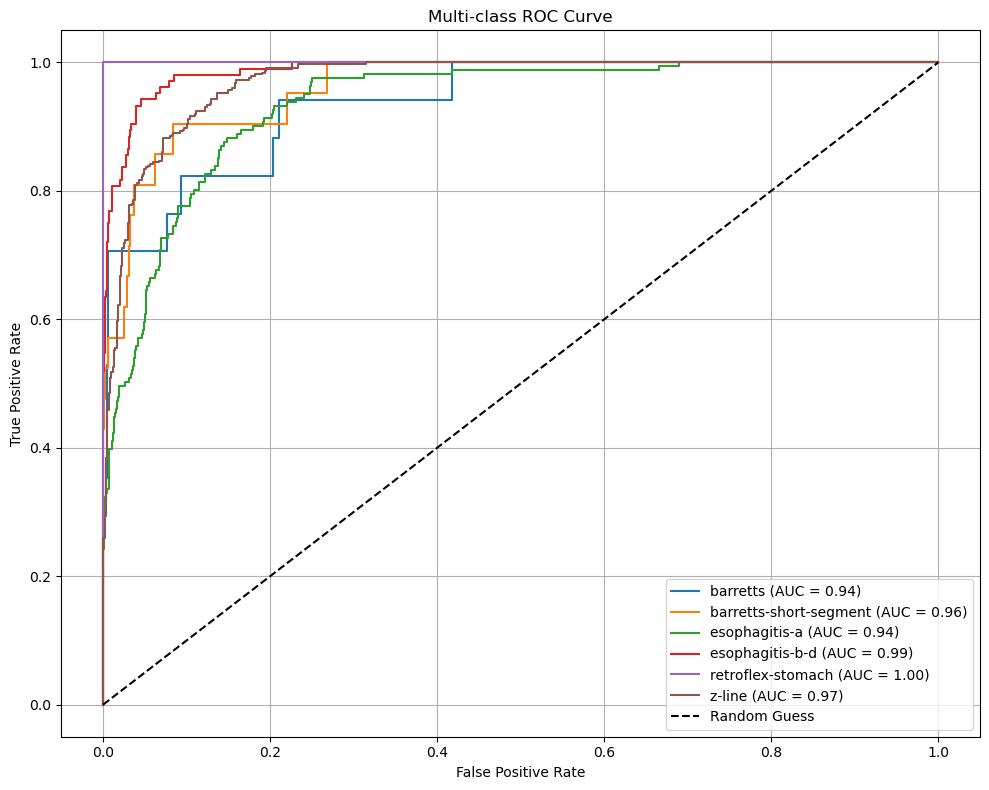

In [94]:
plot_multiclass_auc(all_targets, all_probs, class_names=class_names)

# DenseNet

In [95]:
# 2. Prepare input data: grayscale → RGB
X_rgb = np.repeat(X[:, np.newaxis, :, :], 3, axis=1)  # shape: (N, 3, 224, 224)

In [96]:
# 4. PyTorch Dataset
class ImageDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]


In [97]:
train_loader = DataLoader(ImageDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(ImageDataset(X_val, y_val), batch_size=32)


In [98]:
# 5. Load DenseNet121
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/shreyashindurkar/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████████████████████████████████| 30.8M/30.8M [00:06<00:00, 5.28MB/s]


In [99]:
# 6. Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [100]:
# 7. Train
for epoch in range(5):  # Increase if needed
    model.train()
    running_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


100%|█████████████████████████████████████████| 123/123 [16:09<00:00,  7.88s/it]


Epoch 1, Loss: 83.7335


100%|█████████████████████████████████████████| 123/123 [15:56<00:00,  7.78s/it]


Epoch 2, Loss: 42.9689


100%|█████████████████████████████████████████| 123/123 [14:52<00:00,  7.26s/it]


Epoch 3, Loss: 18.6216


100%|█████████████████████████████████████████| 123/123 [14:35<00:00,  7.12s/it]


Epoch 4, Loss: 9.4677


100%|█████████████████████████████████████████| 123/123 [14:46<00:00,  7.21s/it]

Epoch 5, Loss: 4.7956


In [101]:
# 8. Evaluate
model.eval()
all_preds = []
all_probs = []
all_targets = []

In [102]:
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(labels.numpy())

100%|███████████████████████████████████████████| 31/31 [01:29<00:00,  2.90s/it]


In [103]:
# 9. Metrics
print(classification_report(all_targets, all_preds, target_names=class_names))

                        precision    recall  f1-score   support

              barretts       0.88      0.41      0.56        17
barretts-short-segment       1.00      0.48      0.65        21
         esophagitis-a       0.69      0.70      0.70       161
       esophagitis-b-d       0.81      0.88      0.84       104
     retroflex-stomach       1.00      1.00      1.00       306
                z-line       0.88      0.90      0.89       373

              accuracy                           0.88       982
             macro avg       0.88      0.73      0.77       982
          weighted avg       0.88      0.88      0.88       982



In [104]:
# AUC
y_true_bin = label_binarize(all_targets, classes=list(range(num_classes)))
y_prob_bin = np.array(all_probs)
auc_score = roc_auc_score(y_true_bin, y_prob_bin, average='macro', multi_class='ovr')
print(f"Macro AUC Score: {auc_score:.4f}")

Macro AUC Score: 0.9726


In [105]:
# 10. Plot ROC Curve
def plot_multiclass_auc(all_targets, all_probs, class_names):
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)
    y_true_bin = label_binarize(all_targets, classes=list(range(len(class_names))))
    
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve (DenseNet121)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

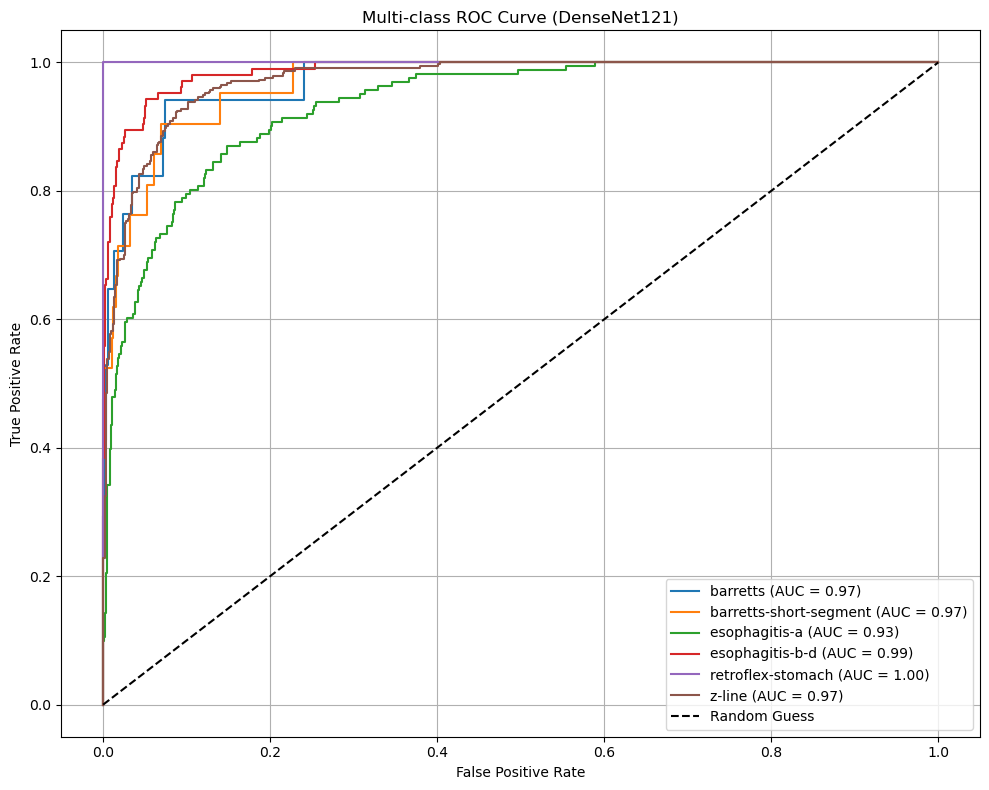

In [106]:
plot_multiclass_auc(all_targets, all_probs, class_names=class_names)